# **CLUSTERING (AGRUPACIÓN) DE SEMILLAS**
- Alfredo Marías Felices Vera 100495820@alumnos.uc3m.es
- Liang Ji Zhu 100495723@alumnos.uc3m.es
- Grupo 20

# 1. **Cargar datos**

In [254]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage


# Establecer semilla aleatoria
SEED = 100495820
np.random.seed(SEED)

# Cargar datos
data = pd.read_csv('data/semillas.csv')
X = data.iloc[:, :-1]  # Asumimos que las características están en todas las columnas excepto la última
y = data.iloc[:, -1]   # Asumimos que la última columna contiene las etiquetas


# 2. Evaluacion de Escalers mediante PCA
- Se evalúa aquí cuál de los tres scalers: MinMaxScaler, RobustScaler y StandardScaler que son más indicados para el problema. Para ello, hacemos un pipeline que en primer lugar aplica uno de ellos y, en segundo lugar, realiza una reducción de dimension mediante PCA a dos con dos componentes. Lo que se pretende es transformar los datos en un espacio bidimensional para poder graficarlos y observar cómo cada scaler modifica distribución y discriminación entre datos. Lo que esperamos obtener es un esquema gráfico de las transformaciones realizadas cada uno de los escaladores sobre los datos.

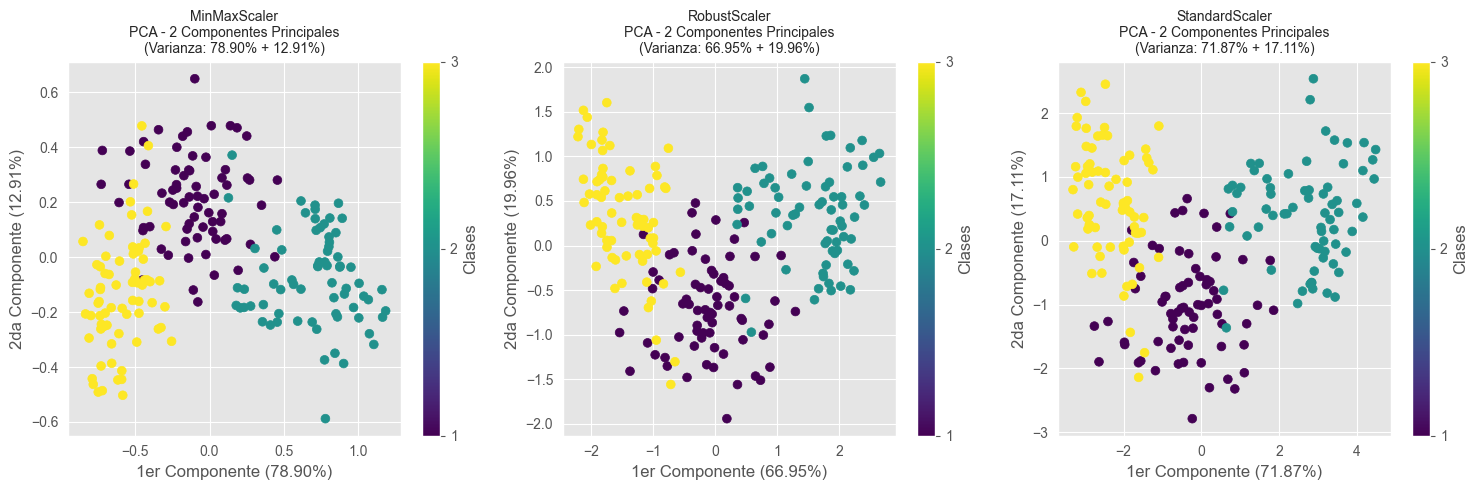

In [255]:
# Lista de scalers
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler()
}

# Visualización
plt.figure(figsize=(15, 5))
for i, (scaler_name, scaler) in enumerate(scalers.items(), 1):
    # Pipeline con scaler y PCA
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=SEED))
    ])

    # Transformar datos
    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']
    explained_variance = pca.explained_variance_ratio_

    # Gráfico
    plt.subplot(1, 3, i)
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', s=40)
    plt.title(f'{scaler_name}\nPCA - 2 Componentes Principales\n(Varianza: {explained_variance[0]:.2%} + {explained_variance[1]:.2%})', fontsize=10)
    plt.xlabel('1er Componente ({:.2%})'.format(explained_variance[0]))
    plt.ylabel('2da Componente ({:.2%})'.format(explained_variance[1]))
    plt.colorbar(ticks=range(4), label='Clases')

plt.tight_layout()
plt.show()

- Hemos decidido utilizar MinMaxScaler porque al hacer el escalado los datos en un rango de 0 a 1, se logra mantener y resaltar la variabilidad original de las características, lo que se traduce en un mayor porcentaje de varianza acumulada en los dos componentes del PCA. También esto facilita la visualización de agrupaciones más definidas del conjunto de datos en 2D.

# 3. Clustering

In [256]:
# Pipeline con scaler MinMax
scaler = MinMaxScaler()
pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=SEED))
    ])
# Reducir a 2D con PCA
pca = PCA(n_components=2, random_state=SEED)
X_2D = pipeline.fit_transform(X)
df_pca = pd.DataFrame(X_2D, columns=['PC1', 'PC2'])

## 1. K-Means

- K-Means es un algoritmo de agrupamiento que busca dividir un conjunto de datos en k grupos (clusters) basándose en la distancia entre los puntos. Primero habra que determinar el número óptimo de clusters (K) para el conjunto de datos. Para ello, se utiliza el método del codo, que consiste en calcular la inercia (suma de las distancias al cuadrado entre los puntos y sus centroides) para diferentes valores de K y graficar estos valores. El punto donde la inercia deja de disminuir significativamente indica el número óptimo de clusters.

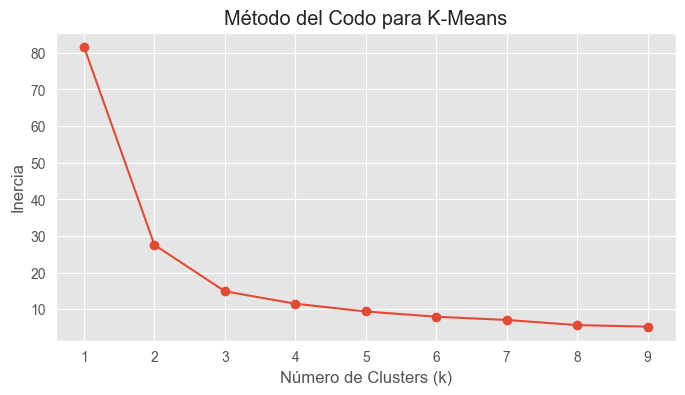

In [257]:
# Determinar el número óptimo de clusters con el método del codo
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(X_2D)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

- La solucion óptima es K=3, ya que es el punto donde la inercia deja de disminuir significativamente. A partir de este punto, la disminución de la inercia es menos pronunciada, lo que indica que agregar más clusters no mejora significativamente la calidad del agrupamiento.

In [258]:
# Elegir k=3 y aplicar K-Means
kmeans = KMeans(n_clusters=3,n_init=25, random_state=SEED)
kmeans_labels = kmeans.fit_predict(X_2D)
df_pca['KMeans'] = kmeans_labels

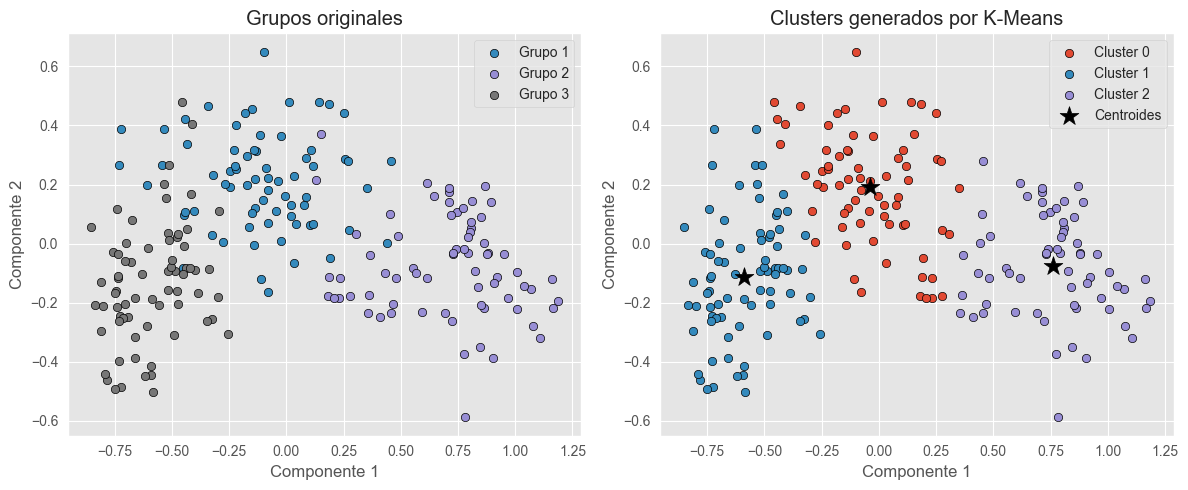

In [259]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_2D[y == i, 0],
        y = X_2D[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label     = f"Grupo {i}"
    )

ax[0].set_title('Grupos originales')
ax[0].set_xlabel('Componente 1')
ax[0].set_ylabel('Componente 2')
ax[0].legend()

# Clusters generados por K-Means
for i in np.unique(kmeans.labels_):
    ax[1].scatter(
        x = X_2D[kmeans.labels_ == i, 0],
        y = X_2D[kmeans.labels_ == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label     = f"Cluster {i}"
    )

# Centroides de K-Means
ax[1].scatter(
    x = kmeans.cluster_centers_[:, 0],
    y = kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'Centroides'
)

ax[1].set_title('Clusters generados por K-Means')
ax[1].set_xlabel('Componente 1')
ax[1].set_ylabel('Componente 2')
ax[1].legend()

plt.tight_layout()
plt.show()

## 2. Clustering Jerárquico

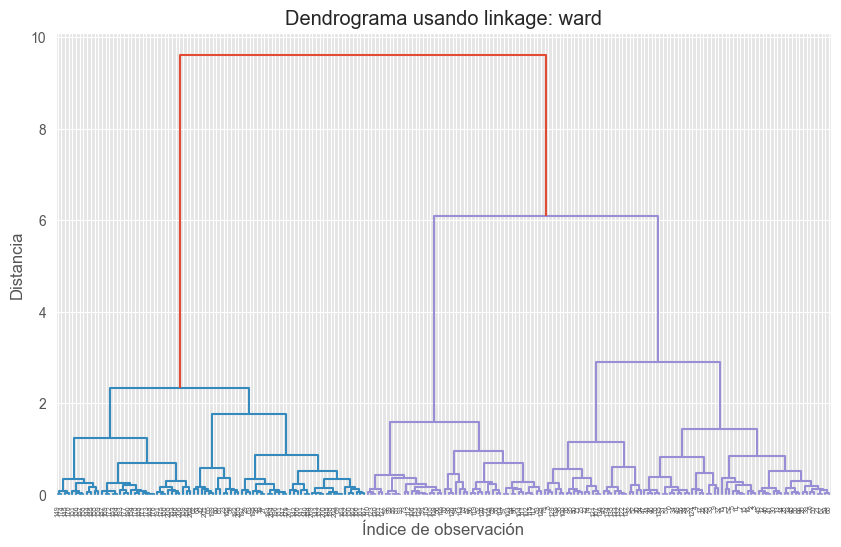

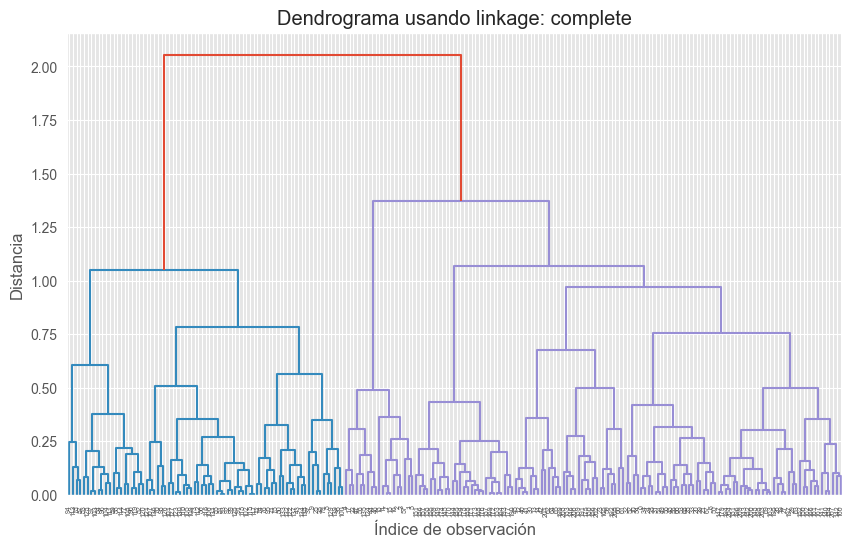

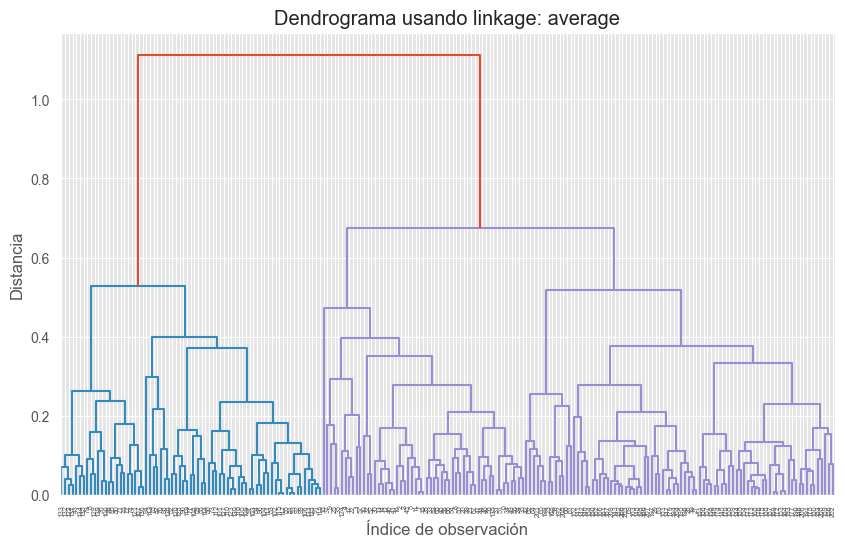

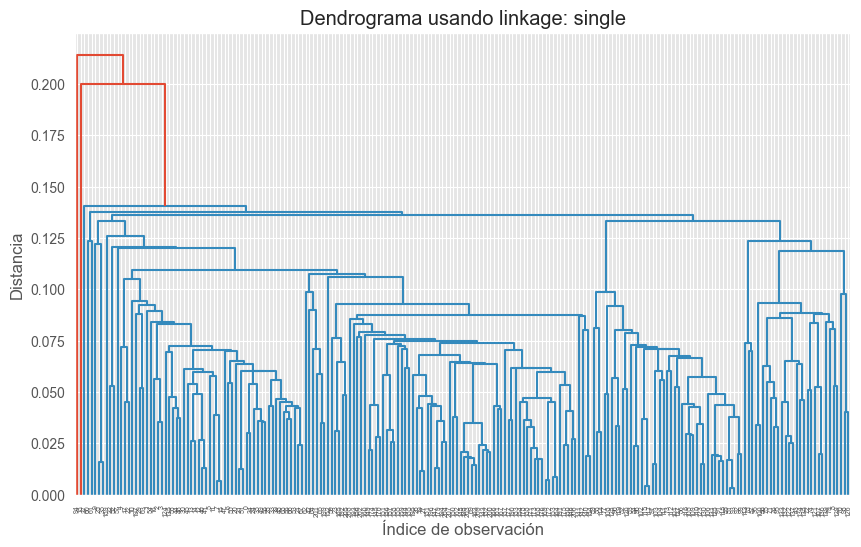

In [260]:
# Crear dendrograma para determinar el número de clusters
linkage_methods = ['ward', 'complete', 'average', 'single']

for method in linkage_methods:
    plt.figure(figsize=(10, 6))
    # Calcular la matriz de linkage para el método actual
    linkage_matrix = linkage(X_2D, method=method)
    # Graficar el dendrograma
    dendrogram(linkage_matrix)
    plt.title(f'Dendrograma usando linkage: {method}')
    plt.xlabel('Índice de observación')
    plt.ylabel('Distancia')
    plt.show()

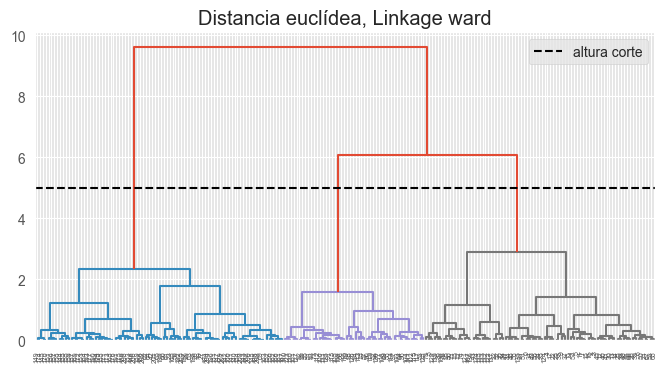

In [261]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 5
linkage_matrix = linkage(X_2D, method='ward')
dendrogram(linkage_matrix, labels=df_pca.index, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

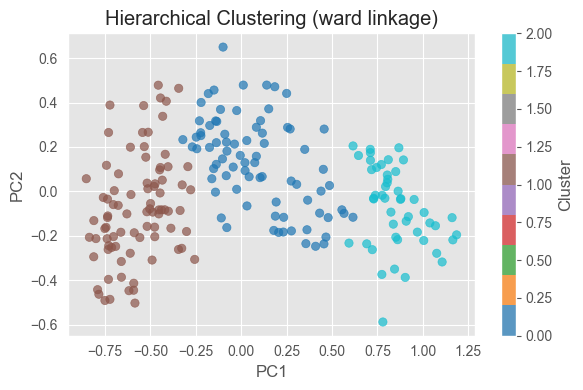

In [262]:
# Elegir 3 clusters y aplicar Agglomerative Clustering
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_2D)
df_pca['Hierarchical'] = hierarchical_labels

plt.figure(figsize=(6,4))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=hierarchical_labels, cmap='tab10', alpha=0.7)
plt.title("Hierarchical Clustering (ward linkage)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


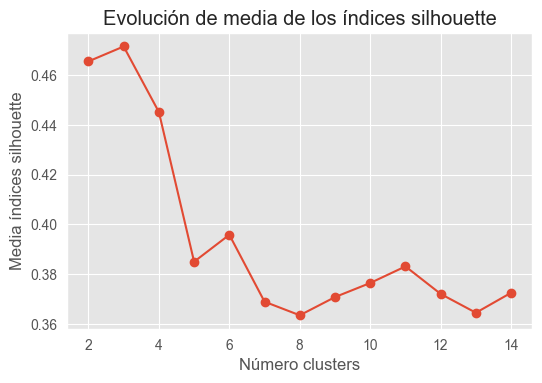

In [263]:
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_2D)
    silhouette_avg = silhouette_score(X_2D, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Número óptimo de clusters: 2
Altura de fusión óptima: 2.20


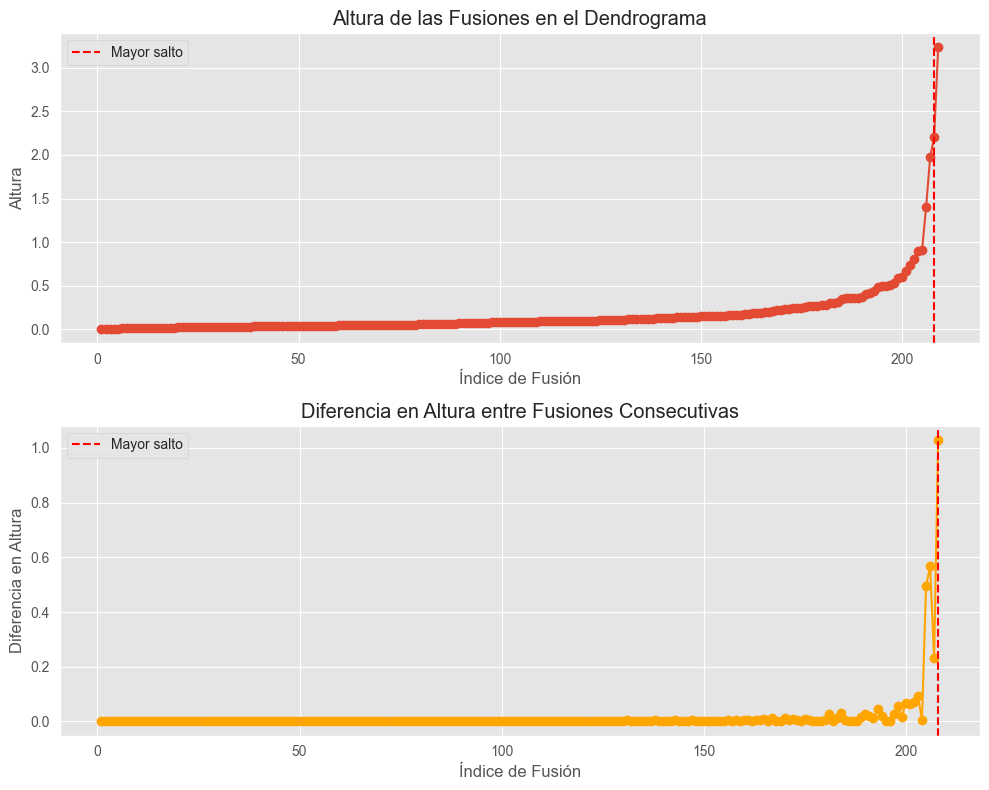

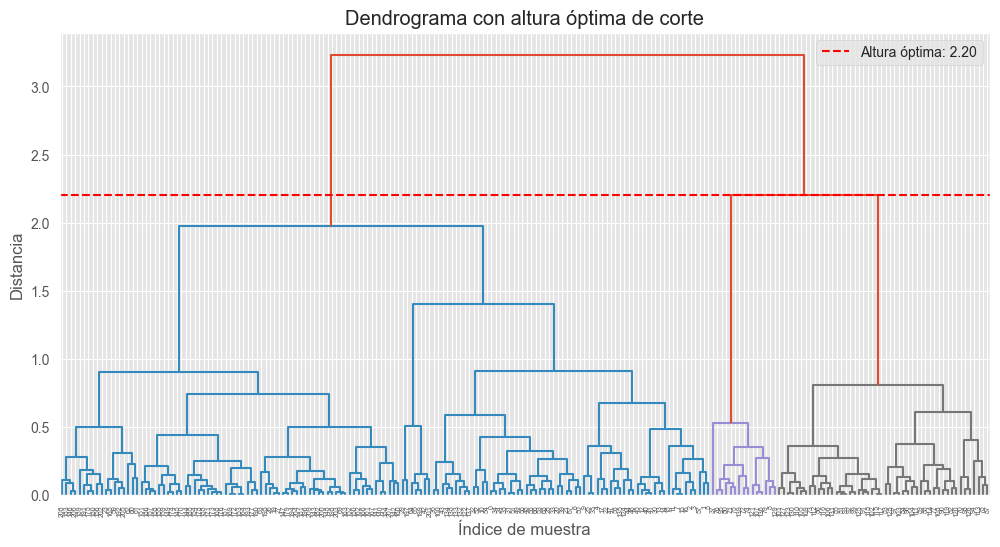

In [264]:
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt


datos_scaled = df_pca
# Calculamos la matriz de enlace con linkage 'complete'
Z = sch.linkage(datos_scaled, method='complete')

# Extraemos las alturas de fusión
heights = Z[:, 2]  # La tercera columna contiene las alturas de fusión

# Calculamos las diferencias entre alturas consecutivas
diffs = np.diff(heights)

# Índice donde ocurre el mayor salto en altura
idx_max_jump = np.argmax(diffs)

# Número óptimo de clusters basado en el mayor salto
n_clusters_optimo = len(heights) - idx_max_jump

# Altura de fusión en el mayor salto
altura_optima = heights[idx_max_jump]

print(f"Número óptimo de clusters: {n_clusters_optimo}")
print(f"Altura de fusión óptima: {altura_optima:.2f}")

# Ahora ploteamos la información

# Graficamos la altura de fusión y su incremento
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico de las alturas de fusión
ax[0].plot(range(1, len(heights) + 1), heights, marker='o', linestyle='-')
ax[0].set_title("Altura de las Fusiones en el Dendrograma")
ax[0].set_xlabel("Índice de Fusión")
ax[0].set_ylabel("Altura")
ax[0].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[0].legend()

# Gráfico del incremento en altura
ax[1].plot(range(1, len(diffs) + 1), diffs, marker='o', linestyle='-', color='orange')
ax[1].set_title("Diferencia en Altura entre Fusiones Consecutivas")
ax[1].set_xlabel("Índice de Fusión")
ax[1].set_ylabel("Diferencia en Altura")
ax[1].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[1].legend()

plt.tight_layout()
plt.show()

# Graficamos el dendrograma
plt.figure(figsize=(12, 6))
sch.dendrogram(Z, color_threshold=altura_optima)  # Coloriza los clusters a esa altura
plt.axhline(y=altura_optima, color='r', linestyle='dashed', label=f'Altura óptima: {altura_optima:.2f}')
plt.title("Dendrograma con altura óptima de corte")
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia")
plt.legend()
plt.show()

## 3. DBSCAN

In [265]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

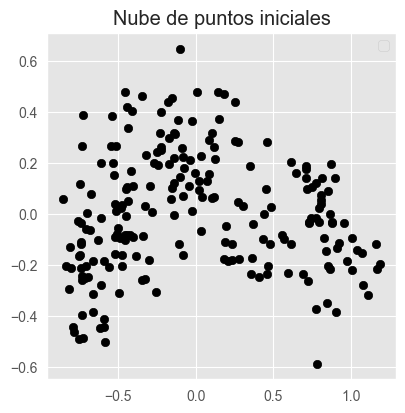

In [266]:
from sklearn.preprocessing import StandardScaler

# Escalado de datos
# ==============================================================================
X_scaled = X_2D
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    c='black',
    marker='o',
    edgecolor='black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

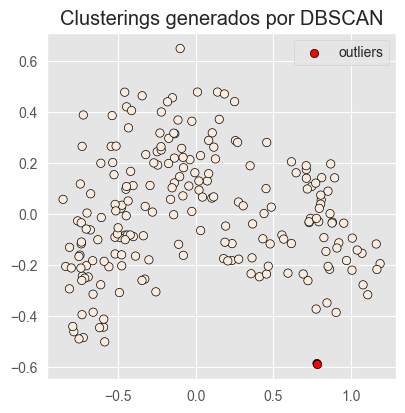

In [267]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps=0.2,
    min_samples=5,
    metric='euclidean',
)

modelo_dbscan.fit(X=X_scaled)
# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    c=labels,
    marker='o',
    edgecolor='black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x=X_scaled[labels == -1, 0],
    y=X_scaled[labels == -1, 1],
    c='red',
    marker='o',
    edgecolor='black',
    label='outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [268]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 1
Número de outliers encontrados: 1


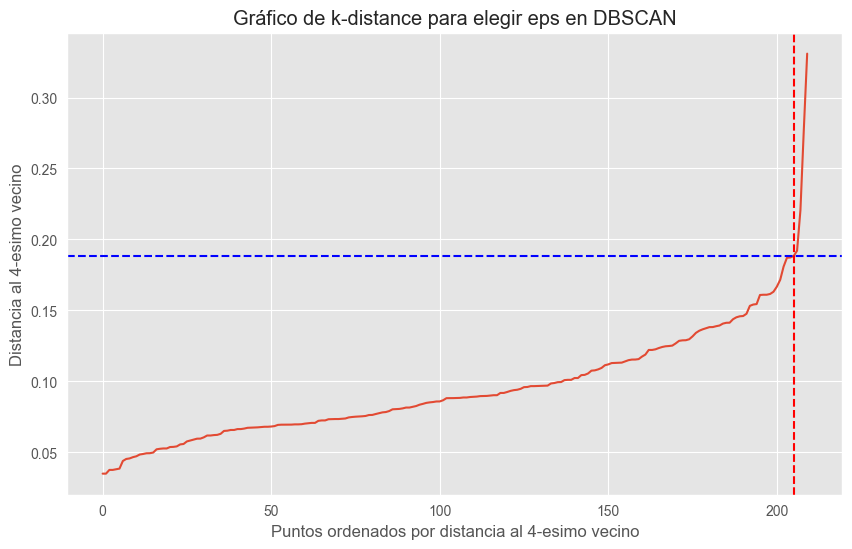

x_point=205 y_value=0.18837255813329848


In [269]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 5

# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples - 1], axis=0)

x_point = 205
y_value = sorted_distances[x_point]  # Obtener el valor de la distancia para ese punto

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel('Puntos ordenados por distancia al {}-esimo vecino'.format(min_samples - 1))
plt.ylabel('Distancia al {}-esimo vecino'.format(min_samples - 1))
plt.title('Gráfico de k-distance para elegir eps en DBSCAN')

plt.axvline(x=x_point, color='r', linestyle='--')

# Dibujar la línea horizontal correspondiente en el eje Y
plt.axhline(y=y_value, color='b', linestyle='--')

plt.grid(True)
plt.show()

print(f'{x_point=} y_value={y_value}')

Número de clusters encontrados: 1
Número de outliers encontrados: 2


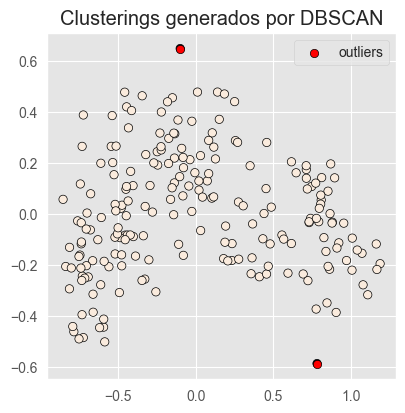

In [270]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
eps = y_value,
min_samples = 5,
metric = 'euclidean',
)

modelo_dbscan.fit(X=X_scaled)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
x = X_scaled[:, 0],
y = X_scaled[:, 1],
c = labels,
marker = 'o',
edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
x = X_scaled[labels == -1, 0],
y = X_scaled[labels == -1, 1],
c = 'red',
marker = 'o',
edgecolor = 'black',
label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')





## 4. Evaluacion

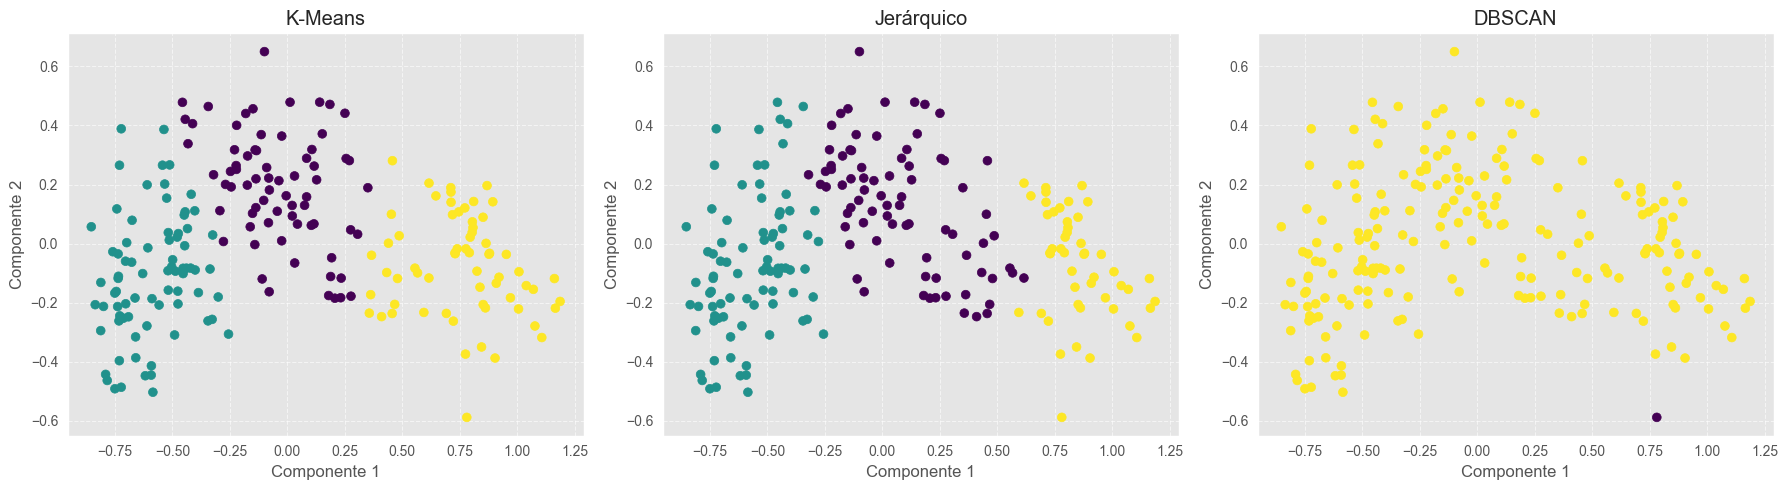

In [271]:
# Ajustar hiperparámetros eps y min_samples
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_2D)

# Visualización de resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
algorithms = {
    'K-Means': kmeans_labels,
    'Jerárquico': hierarchical_labels,
    'DBSCAN': dbscan_labels
}

for ax, (name, labels) in zip(axes, algorithms.items()):
    ax.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='viridis', s=40)
    ax.set_title(name)
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 4. Evaluación de Silueta

In [272]:
# Evaluación de Silueta (excepto DBSCAN con ruido)
print("Puntajes de Silueta:")
print(f"K-Means: {silhouette_score(X_2D, kmeans_labels):.2f}")
print(f"Jerárquico: {silhouette_score(X_2D, hierarchical_labels):.2f}")


#

Puntajes de Silueta:
K-Means: 0.50
Jerárquico: 0.47
